In [33]:
import pandas as pd
import numpy as np
import networkx as nx
from dowhy import CausalModel
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from xgboost import XGBRegressor

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta.tmle import TMLELearner
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel, GradientBoostedPropensityModel
from causalml.dataset import *
from causalml.metrics import *
from causalml.inference.tree import CausalRandomForestRegressor
warnings.filterwarnings("ignore", category=FutureWarning)


In [34]:
df = pd.read_csv("C:/Users/hanch/OneDrive/Desktop/research/NHEFS/NHEFS.csv")

covariates = [
    "qsmk",
    "wt82_71",
    "sex",
    "age",
    "race",
    "education",
    "smokeintensity",
    "smokeyrs",
    "active",
    "exercise",
    "wt71"
]

df = df[covariates]
df = df.dropna(subset=["qsmk", "wt82_71"])
print(df.head(1))


   qsmk   wt82_71  sex  age  race  education  smokeintensity  smokeyrs  \
0     0 -10.09396    0   42     1          1              30        29   

   active  exercise   wt71  
0       0         2  79.04  


['qsmk', 'wt82_71', 'sex', 'age', 'race', 'education', 'smokeintensity', 'smokeyrs', 'active', 'exercise', 'wt71']


  0%|          | 0/11 [00:00<?, ?it/s]

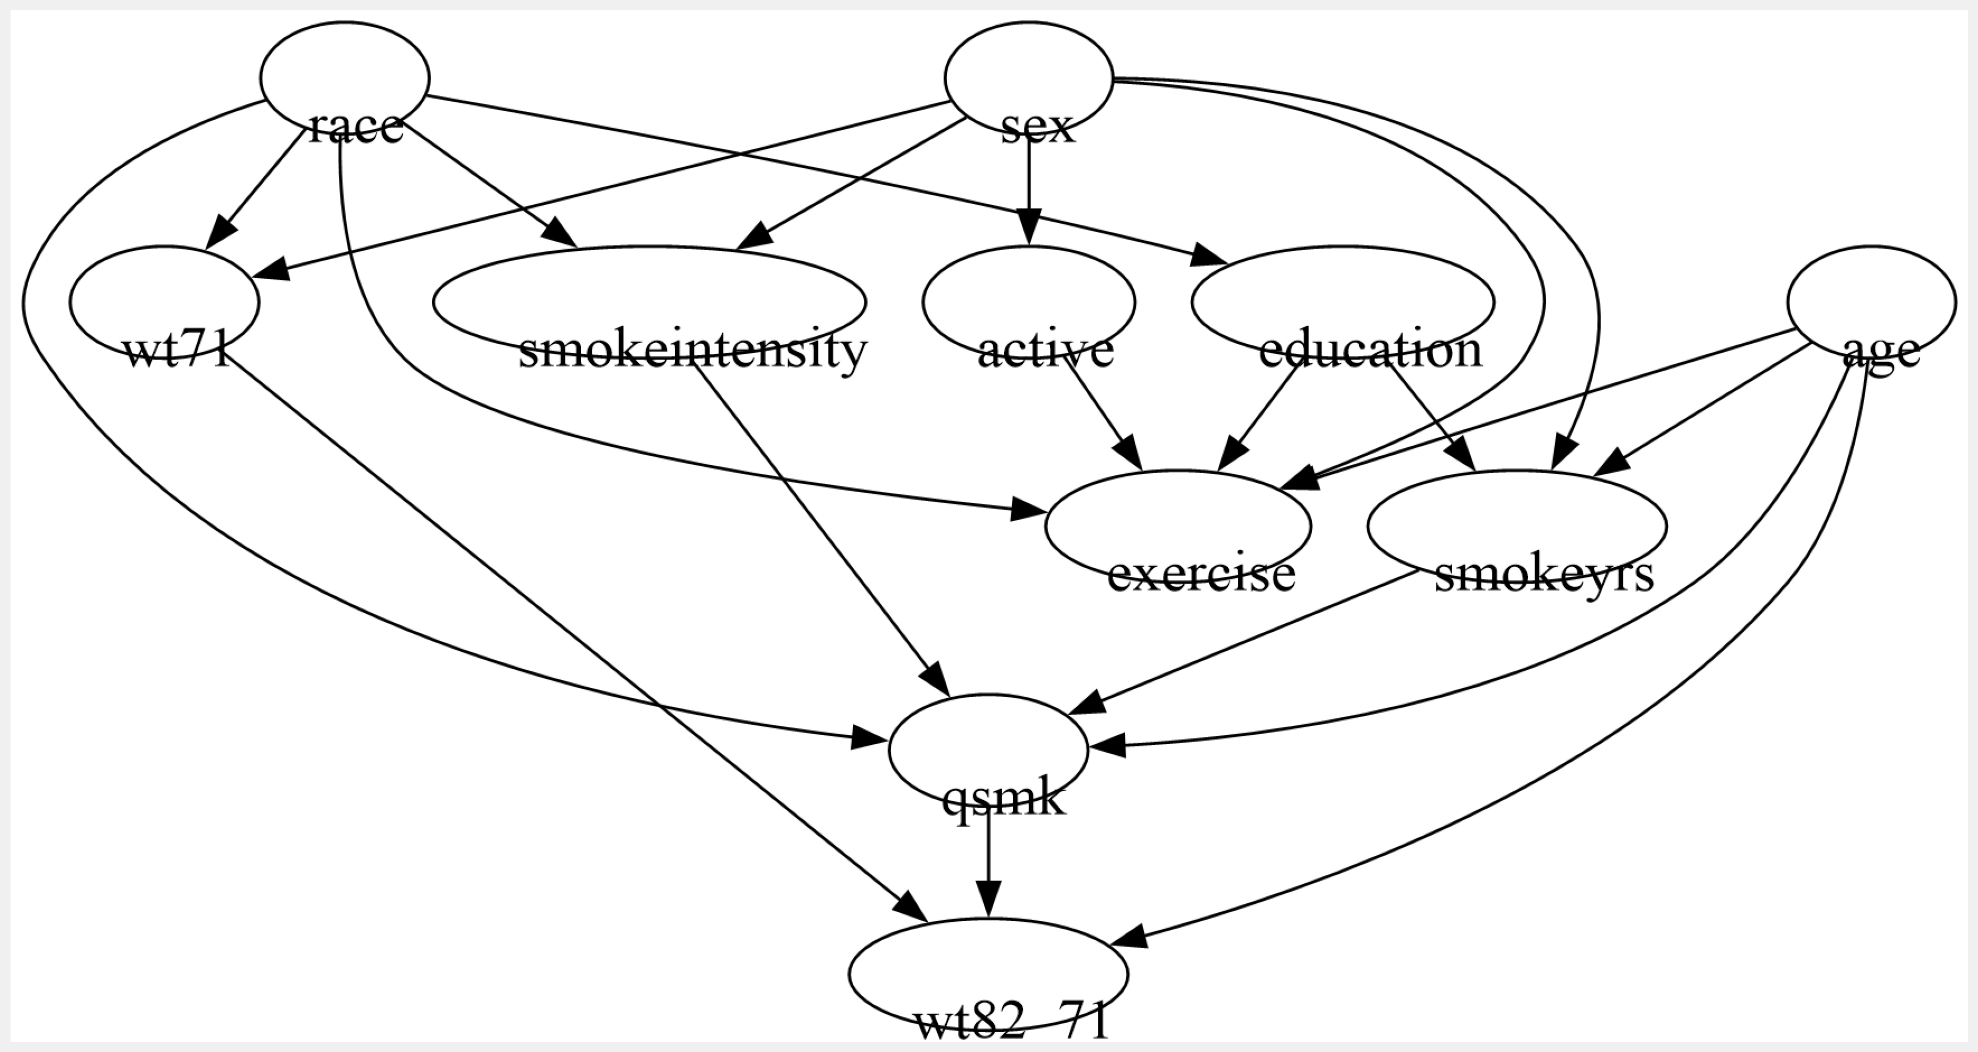

qsmk -> ['wt82_71']
wt82_71 -> []
sex -> ['smokeintensity', 'smokeyrs', 'active', 'exercise', 'wt71']
age -> ['qsmk', 'wt82_71', 'smokeyrs', 'exercise']
race -> ['qsmk', 'education', 'smokeintensity', 'exercise', 'wt71']
education -> ['smokeyrs', 'exercise']
smokeintensity -> ['qsmk']
smokeyrs -> ['qsmk']
active -> ['exercise']
exercise -> []
wt71 -> ['wt82_71']


In [35]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.graph.GraphClass import CausalGraph

nhefs = df.copy()
cols = list(nhefs.columns)
print(cols)
protected = ["sex", "race", "age"]
bk = BackgroundKnowledge()
cg = CausalGraph(len(cols))
nodes = cg.G.get_nodes()

for i, a in enumerate(cols):
    for b in protected:
        if a != b:
            index_b = cols.index(b)
            bk.add_forbidden_by_node(nodes[i], nodes[index_b])

cg = pc(nhefs.to_numpy(), 0.05, "mv_fisherz", True, 0, 0, mvpc=True, background_knowledge=bk)

cg.draw_pydot_graph(labels=list(nhefs.columns))
#cg.draw_pydot_graph()


def cg_to_nx_dag(cg, labels):
    Gmat = cg.G.graph 
    n = Gmat.shape[0]
    G = nx.DiGraph()
    G.add_nodes_from(labels)
    
    for i in range(n):
        for j in range(i + 1, n):
            a, b = Gmat[j, i], Gmat[i, j]
            
            if a == 1 and b == -1:       # i -> j
                G.add_edge(labels[i], labels[j])
                
            elif a == -1 and b == 1:     # j -> i
                G.add_edge(labels[j], labels[i])
    return G

nx_graph = cg_to_nx_dag(cg, cols)
for node in nx_graph.nodes:
    print(node, "->", list(nx_graph.successors(node))) 

In [37]:
"""
    causal graph generated by GPT

"""

data_dict1 = {
    "data": df,
    "treatment": ["qsmk"],
    "outcome": ["wt82_71"],
    "graph": """
graph [
  directed 1

  node [ id "qsmk" label "qsmk" ]
  node [ id "wt82_71" label "wt82_71" ]
  node [ id "smokeintensity" label "smokeintensity" ]
  node [ id "smokeyrs" label "smokeyrs" ]
  node [ id "active" label "active" ]
  node [ id "exercise" label "exercise" ]
  node [ id "wt71" label "wt71" ]
  node [ id "sex" label "sex" ]
  node [ id "age" label "age" ]
  node [ id "race" label "race" ]
  node [ id "education" label "education" ]

  edge [ source "qsmk" target "wt82_71" ]
  edge [ source "smokeintensity" target "qsmk" ]
  edge [ source "smokeyrs" target "qsmk" ]
  edge [ source "smokeintensity" target "wt71" ]
  edge [ source "smokeyrs" target "wt71" ]
  edge [ source "active" target "qsmk" ]
  edge [ source "exercise" target "qsmk" ]
  edge [ source "active" target "wt82_71" ]
  edge [ source "exercise" target "wt82_71" ]
  edge [ source "wt71" target "wt82_71" ]
  edge [ source "sex" target "qsmk" ]
  edge [ source "sex" target "wt71" ]
  edge [ source "age" target "qsmk" ]
  edge [ source "age" target "smokeyrs" ]
  edge [ source "age" target "wt71" ]
  edge [ source "race" target "qsmk" ]
  edge [ source "education" target "qsmk" ]
  edge [ source "education" target "smokeintensity" ]
  edge [ source "education" target "active" ]
  edge [ source "education" target "exercise" ]
]
"""
}
print(data["data"].head(1))


   qsmk   wt82_71  sex  age  race  education  smokeintensity  smokeyrs  \
0     0 -10.09396    0   42     1          1              30        29   

   active  exercise   wt71  
0       0         2  79.04  


In [38]:
"""
    causal graph generated by PC algorithm

"""
nx_graph =  cg_to_nx_dag(cg, cols)

data_dict2 = {
    "data": df,
    "treatment": ["qsmk"],
    "outcome": ["wt82_71"],
    "graph": nx_graph
}

In [39]:
def get_model(data_dict):
    model = CausalModel(
        data = data_dict["data"].copy(),
        treatment = data_dict["treatment"],
        outcome = data_dict["outcome"],
        graph = data_dict["graph"]
    )
    return model

In [40]:
def identify(data_dict):
    model = get_model(data_dict)
    model.view_model()
    identified_estimand = model.identify_effect(proceed_when_unidentifiable = True)
    print(identified_estimand.get_backdoor_variables())
    print()
    print(identified_estimand)
    

In [45]:
def estimate(data_dict):
    model = get_model(data_dict)
    identified_estimand = model.identify_effect(proceed_when_unidentifiable = True)
    
    """
        backdoor.propensity_score_stratification
    """
    model = get_model(data_dict)
    #print(model._data.head(1))
    identified_estimand = model.identify_effect(proceed_when_unidentifiable = True)
    causal_estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.propensity_score_stratification")
    print("Estimating Using backdoor.propensity_score_stratification:")
    print(causal_estimate.value)
    print(causal_estimate.get_confidence_intervals(confidence_level=0.95))
    print("----------------------------------------------------------")
    print()
    
    """
        backdoor.propensity_score_weighting
    """
    model = get_model(data_dict)
    #print(model._data.head(1))
    causal_estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.propensity_score_weighting")
    print("Estimating Using backdoor.propensity_score_weighting:")
    print(causal_estimate.value)
    print(causal_estimate.get_confidence_intervals(confidence_level=0.95))
    print("----------------------------------------------------------")
    print()
    
    
    """
        backdoor.propensity_score_matching
    """
    model = get_model(data_dict)
    #print(model._data.head(1))
    causal_estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.propensity_score_matching")
    print("Estimating Using backdoor.propensity_score_matching:")
    print(causal_estimate.value)
    print(causal_estimate.get_confidence_intervals(confidence_level=0.95))
    print("----------------------------------------------------------")
    print()

    """
        backdoor.generalized_linear_model
    """
    model = get_model(data_dict)
    #print(model._data.head(1))
    causal_estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.generalized_linear_model",
            method_params={
                "glm_family": sm.families.Gaussian()
            }
        )
    print("Estimating Using backdoor.generalized_linear_model:")
    print(causal_estimate.value)
    print(causal_estimate.get_confidence_intervals(confidence_level=0.95))
    print("----------------------------------------------------------")
    print()

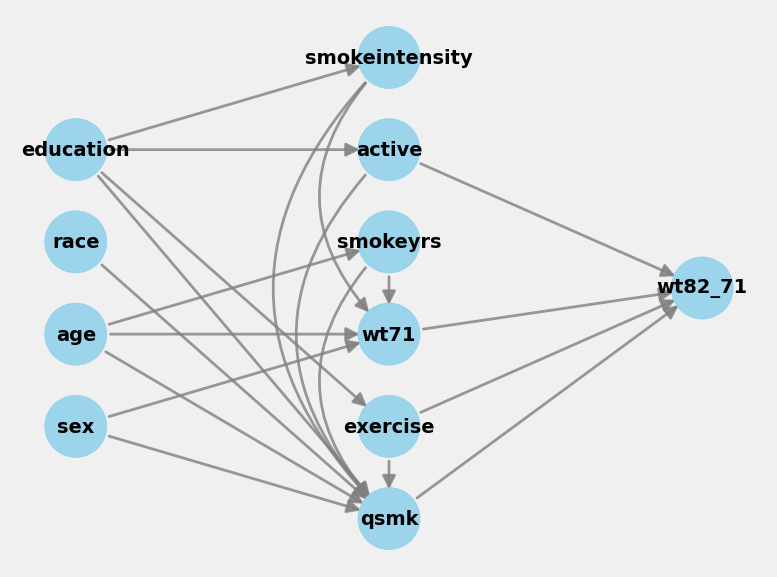

['exercise', 'wt71', 'active']

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                     
───────(E[wt_82_71|exercise,wt71,active])
d[qsmk]                                  
Estimand assumption 1, Unconfoundedness: If U→{qsmk} and U→wt82_71 then P(wt82_71|qsmk,exercise,wt71,active,U) = P(wt82_71|qsmk,exercise,wt71,active)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                  -1⎤
 ⎢   d             ⎛   d           ⎞  ⎥
E⎢───────(wt₈₂ ₇₁)⋅⎜───────([qsmk])⎟  ⎥
 ⎣d[race]          ⎝d[race]        ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→wt82_71 then ¬(U →→{race})
Estimand assumption 2, Exclusion: If we remove {race}→{qsmk}, then ¬({race}→wt82_71)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
   d                                                                

In [46]:
identify(data_dict1)

In [47]:
estimate(data_dict1)

Estimating Using backdoor.propensity_score_stratification:
2.6612501705972433
(1.540753522314192, 3.79901425995821)
----------------------------------------------------------

Estimating Using backdoor.propensity_score_weighting:
2.744161904351693
(1.7992473903919715, 3.646055971630318)
----------------------------------------------------------

Estimating Using backdoor.propensity_score_matching:
2.3618532040613025
(1.2478784725287353, 3.325717995491698)
----------------------------------------------------------

Estimating Using backdoor.generalized_linear_model:
2.7380124584171277
(1.750200086649238, 3.771542413272739)
----------------------------------------------------------



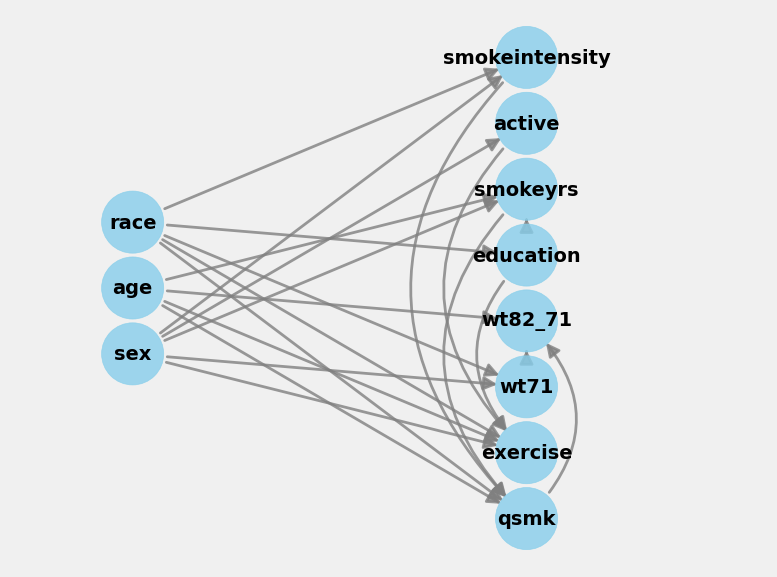

['wt71', 'age']

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
───────(E[wt_82_71|wt71,age])
d[qsmk]                      
Estimand assumption 1, Unconfoundedness: If U→{qsmk} and U→wt82_71 then P(wt82_71|qsmk,wt71,age,U) = P(wt82_71|qsmk,wt71,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
   d                                                 
───────(E[wt_82_71|smokeyrs,age,race,smokeintensity])
d[qsmk]                                              
Estimand assumption 1, Unconfoundedness: If U→{qsmk} and U→wt82_71 then P(wt82_71|qsmk,smokeyrs,age,race,smokeintensity,U) = P(wt82_71|qsmk,smokeyrs,age,race,smokeintensity)



In [48]:
identify(data_dict2)

In [49]:
estimate(data_dict2)

Estimating Using backdoor.propensity_score_stratification:
3.207384456939392
(2.1866644680910987, 4.04156270057581)
----------------------------------------------------------

Estimating Using backdoor.propensity_score_weighting:
3.2474544575103175
(2.4049037486916722, 4.324609666126164)
----------------------------------------------------------

Estimating Using backdoor.propensity_score_matching:
3.3398864750893997
(2.2786050569476375, 4.055692026551725)
----------------------------------------------------------

Estimating Using backdoor.generalized_linear_model:
3.219098686369596
(2.3874558518378537, 4.12146572735379)
----------------------------------------------------------



In [50]:
nhefs = df.copy()
y, X, treatment = (nhefs["wt82_71"], nhefs.drop(columns=["qsmk", "wt82_71"]), nhefs["qsmk"])

from causalml.propensity import LogisticRegressionPropensityModel

pm = LogisticRegressionPropensityModel(
    clip_bounds=(0.02, 0.98),
    calibrate=True
)

e = pm.fit_predict(X, treatment)
print(e[:30])

[0.14678899 0.25358852 0.1741573  0.38392857 0.3046683  0.1741573
 0.2        0.3046683  0.3046683  0.32       0.30434783 0.1741573
 0.3046683  0.14678899 0.14678899 0.25358852 0.3046683  0.3046683
 0.3046683  0.25358852 0.25358852 0.1741573  0.24102564 0.24102564
 0.2        0.05454545 0.24102564 0.3046683  0.25358852 0.10714286]
